# Анализ данных и проверка гипотез для оптимизации бизнеса аренды самокатов GoFast


Мы получили данные о некоторых пользователях сервиса аренды самокатов GoFast из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти. Начнем наше исследование.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import stats as st
from math import factorial
import numpy as np
import math
from scipy.stats import norm

In [2]:
pd.set_option('display.max_columns', 100) #настраиваем максимальное количество столбцов для отображения 

<h1 style="font-size: 16px;">Шаг 1. Загрузка данных</h1>

Загрузим наши датафреймы, посмотрим на первые строки, изучим общую информацию.

In [50]:
users = pd.read_csv(r'users_go.csv')
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В таблице **users** хранятся данные пользователей сервиса. Таблица содержит 1565 записей. Названия столбцов:  
- `user_id`	- уникальный идентификатор пользователя  
- `name` - имя пользователя  
- `age`	- возраст  
- `city` - город  
- `subscription_type` - тип подписки (free, ultra)

In [51]:
rides = pd.read_csv(r'rides_go.csv')
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В таблице **rides** хранятся данные о поездках. Таблица содержит 18068 записей. Названия столбцов:  
- `user_id` - уникальный идентификатор пользователя  
- `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)  
- `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»  
- `date` - дата совершения поездки

In [52]:
subscriptions = pd.read_csv(r'subscriptions_go.csv')
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Таблица **subscriptions** содержит 2 строки с данными о подписке. Есть всего два типа: free и ultra. Для них есть различия в стоимостях. Столбцы таблицы содержат:  
- `subscription_type` - тип подписки  
- `minute_price` - стоимость одной минуты поездки по данной подписке  
- `start_ride_price` - стоимость начала поездки  
- `subscription_fee` - стоимость ежемесячного платежа

Изучили общую информацию, переходим к предобработке данных.

<h1 style="font-size: 16px;">Шаг 2. Предобработка данных</h1>

Начнем предообработку данных.
Заметили, что в таблице rides дата не приведена к типа datetime, приведем и сразу проверим результат:

In [8]:
rides['date'] = pd.to_datetime(rides['date'], format = '%Y-%m-%d')   
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Проверим, какой период описывают предоставленные данные.

In [9]:
d1 = rides['date'].min().date()
d2 = rides['date'].max().date()
print(f'Поездки были совершены в промежутке с {d1} по {d2}.')

Поездки были совершены в промежутке с 2021-01-01 по 2021-12-30.


В таблице rides данные за 2021 год. Создадим новый столбец с номером месяца, в который была совершена поездка.

In [10]:
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Проверим наличие явных дубликатов и удалим их.

In [11]:
print('Количество явных дубликатов в таблице users:', users.duplicated().sum())
print('Количество явных дубликатов в таблице rides:', rides.duplicated().sum())

Количество явных дубликатов в таблице users: 31
Количество явных дубликатов в таблице rides: 0


In [12]:
users = users.drop_duplicates().reset_index(drop=True)

Пропущенных значений в таблицах нет (судя по info), от явных дубликатор мы избавились, переходим к анализу данных.

<h1 style="font-size: 16px;">Шаг 3. Исследовательский анализ данных</h1>

Проанализируем частоту встречаемости городов в таблице users.

In [13]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

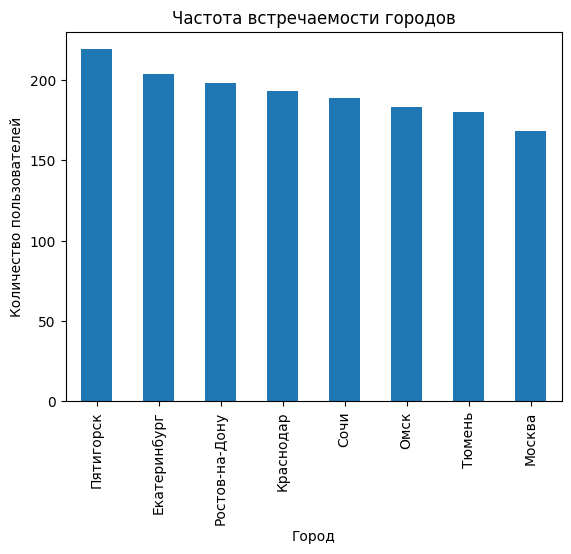

In [14]:
users['city'].value_counts().plot(kind = 'bar', y = 'city');
plt.title('Частота встречаемости городов')
plt.xlabel('Город')
plt.ylabel('Количество пользователей')
plt.show()

Больше всего данных по Пятигорску, меньше всего по Москве, но в целом данные по городам распределены достаточно равномерно.

 Найдем соотношение пользователей с подпиской и без подписки.

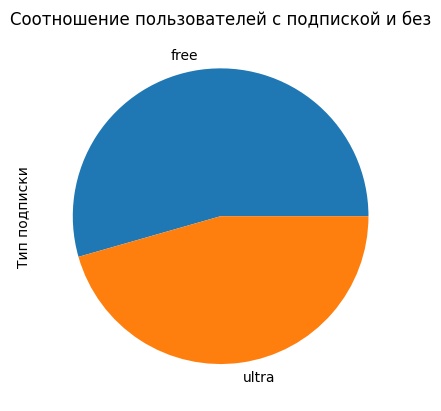

In [15]:
users['subscription_type'].value_counts().plot(kind = 'pie', y = 'subscription_type');
plt.title('Соотношение пользователей с подпиской и без')
plt.ylabel('Тип подписки')
plt.show();

In [16]:
no_sub = (users['subscription_type'].value_counts()[0]*100/(users['subscription_type'].value_counts()[1]+users['subscription_type'].value_counts()[0])).round(2)
with_sub =  (users['subscription_type'].value_counts()[1]*100/(users['subscription_type'].value_counts()[1]+users['subscription_type'].value_counts()[0])).round(2)
print (f'Доля пользователей без подписки - {no_sub}%, доля пользователей с подпиской - {with_sub}%.')


Доля пользователей без подписки - 54.43%, доля пользователей с подпиской - 45.57%.


 Визуализируем возраст пользователей.

In [17]:
users['age'].value_counts().sort_index()

12      4
13      8
14      9
15     13
16     19
17     26
18     46
19     47
20     71
21     93
22    119
23    129
24    132
25    145
26    131
27    119
28    112
29     68
30     68
31     48
32     41
33     39
34     19
35     15
36      6
37      2
38      3
39      1
43      1
Name: age, dtype: int64

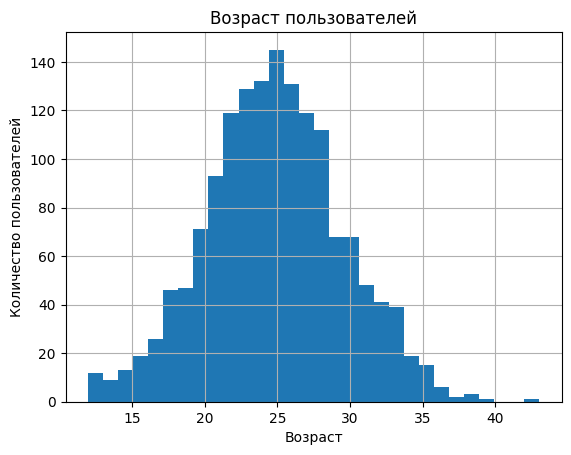

In [18]:
users['age'].hist(bins=30)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()


Возраст пользователей рапределен нормально с пиком в значении 25 лет. Минимальный возраст - 12 лет, максимальный - 43 года.

Проанализируем расстояние, которое пользователь преодолевает за одну поездку, а также продолжительность поездок.

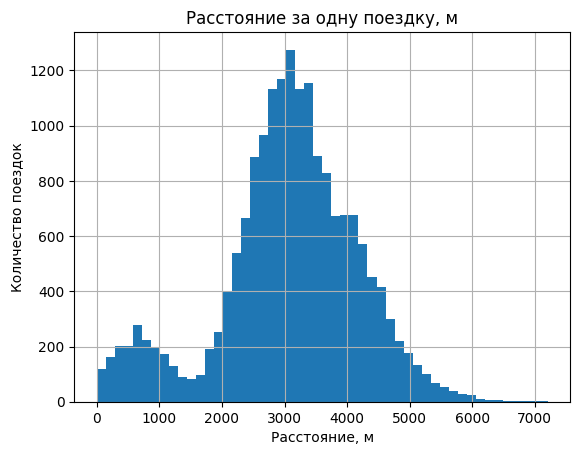

In [19]:
rides['distance'].hist(bins=50)
plt.title('Расстояние за одну поездку, м')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.show()

Преодолеваемое расстояние распределено бимодально, хорошо видны две группы данных.

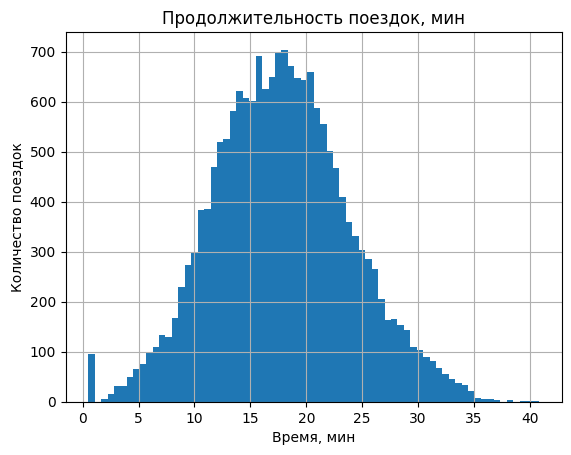

In [20]:
rides['duration'].hist(bins=70)
plt.title('Продолжительность поездок, мин')
plt.xlabel('Время, мин')
plt.ylabel('Количество поездок')
plt.show()

Итак, весь массив поездок мы можем разделить на две части: короткие поездки (вероятно, пробные первые разы, когда человек хочет просто познакомиться с такой возможностью), и обычные поездки.

<h1 style="font-size: 16px;">Шаг 4. Объединение данных</h1>

Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [21]:
full = users.merge(rides, on = 'user_id')
full = full.merge(subscriptions, on = 'subscription_type')
full.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Создадим два отдельных датафрейма: для пользователей с подпиской и без.

In [22]:
no_subscription = full.loc[full.loc[:,'subscription_type']  == 'free']
with_subscription = full.loc[full.loc[:,'subscription_type']  == 'ultra']

Проверим, все ли строки попали в две получившиеся таблицы.

In [23]:
if no_subscription.shape[0] + with_subscription.shape[0] == rides.shape[0]:
    print ('При разделении таблицы строки не потеряны.')
else:
    print ('Сумма строк не совпадает.')

При разделении таблицы строки не потеряны.


Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

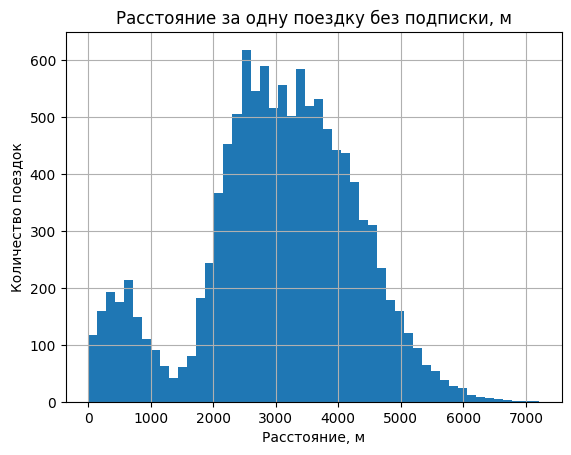

In [24]:
no_subscription['distance'].hist(bins=50)
plt.title('Расстояние за одну поездку без подписки, м')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.show()

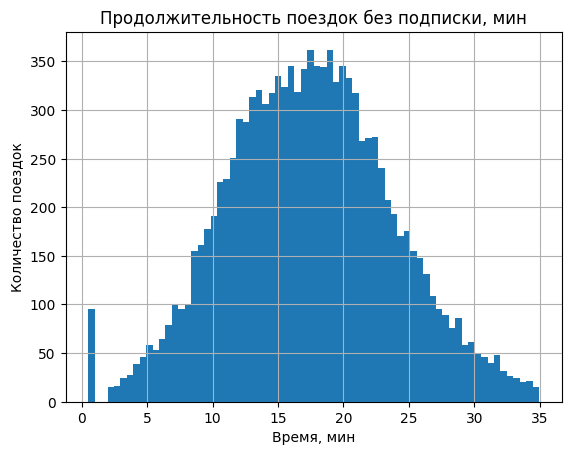

In [25]:
no_subscription['duration'].hist(bins=70)
plt.title('Продолжительность поездок без подписки, мин')
plt.xlabel('Время, мин')
plt.ylabel('Количество поездок')
plt.show()

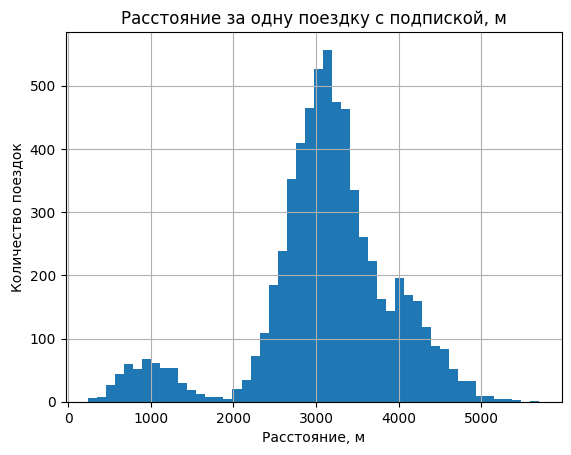

In [26]:
with_subscription['distance'].hist(bins=50)
plt.title('Расстояние за одну поездку c подпиской, м')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.show()

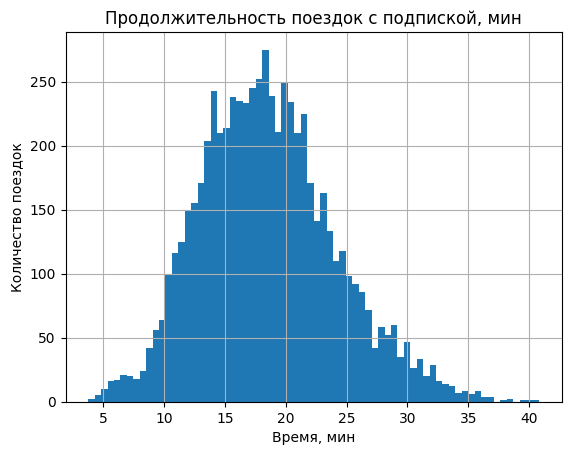

In [27]:
with_subscription['duration'].hist(bins=70)
plt.title('Продолжительность поездок c подпиской, мин')
plt.xlabel('Время, мин')
plt.ylabel('Количество поездок')
plt.show()

Без глубокого анализа по диаграммам можно сказать, что без подписки люди совершают больше коротких поездок, чем с подпиской, а пройденные расстояния с подпиской и без значительно не отличаются.

<h1 style="font-size: 16px;">Шаг 5. Подсчёт</h1>

Создадим новый датафрейм с агрегированными данными о поездках: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [28]:
full_agr = full.groupby(['user_id', 'month']).agg({'date':'count', 'distance':'sum', 'duration':'sum', 'subscription_fee':'first', 'minute_price':'first', 'start_ride_price':'first'})
full_agr['duration'] = np.ceil(full_agr['duration']) 
full_agr['distance'] = np.ceil(full_agr['distance']) 
full_agr = full_agr.rename(columns={'date' : 'rides_count'})
full_agr.head(20)

rides_count  distance  duration  subscription_fee  \
user_id month                                                      
1       1                2    7028.0      42.0               199   
        4                1     755.0       7.0               199   
        8                2    6724.0      45.0               199   
        10               2    5810.0      32.0               199   
        11               3    7004.0      54.0               199   
        12               2    6752.0      28.0               199   
2       3                3   10188.0      61.0               199   
        4                2    6165.0      40.0               199   
        6                1    3256.0      14.0               199   
        7                2    6781.0      47.0               199   
        8                1     924.0       7.0               199   
        10               1    2825.0      19.0               199   
        12               1    3829.0      12.0               199   
3       1                1    3062.0      13.0               199   
        2                2    5422.0      38.0               199   
        4                1    2957.0      21.0               199   
        5                3    9065.0      62.0               199   
        7                3   10920.0      66.0               199   
        9                1    2892.0      23.0               199   
        12               1    2594.0      13.0               199   

               minute_price  start_ride_price  
user_id month                                  
1       1                 6                 0  
        4                 6                 0  
        8                 6                 0  
        10                6                 0  
        11                6                 0  
        12                6                 0  
2       3                 6                 0  
        4                 6                 0  
        6                 6                 0  
        7                 6                 0  
        8                 6                 0  
        10                6                 0  
        12                6                 0  
3       1                 6                 0  
        2                 6                 0  
        4                 6                 0  
        5                 6                 0  
        7                 6                 0  
        9                 6                 0  
        12                6                 0

Добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

In [29]:
full_agr['revenue'] = full_agr['subscription_fee'] + full_agr['duration'] * full_agr['minute_price'] + full_agr['start_ride_price'] * full_agr['rides_count'] 
full_agr.head(20)

rides_count  distance  duration  subscription_fee  \
user_id month                                                      
1       1                2    7028.0      42.0               199   
        4                1     755.0       7.0               199   
        8                2    6724.0      45.0               199   
        10               2    5810.0      32.0               199   
        11               3    7004.0      54.0               199   
        12               2    6752.0      28.0               199   
2       3                3   10188.0      61.0               199   
        4                2    6165.0      40.0               199   
        6                1    3256.0      14.0               199   
        7                2    6781.0      47.0               199   
        8                1     924.0       7.0               199   
        10               1    2825.0      19.0               199   
        12               1    3829.0      12.0               199   
3       1                1    3062.0      13.0               199   
        2                2    5422.0      38.0               199   
        4                1    2957.0      21.0               199   
        5                3    9065.0      62.0               199   
        7                3   10920.0      66.0               199   
        9                1    2892.0      23.0               199   
        12               1    2594.0      13.0               199   

               minute_price  start_ride_price  revenue  
user_id month                                           
1       1                 6                 0    451.0  
        4                 6                 0    241.0  
        8                 6                 0    469.0  
        10                6                 0    391.0  
        11                6                 0    523.0  
        12                6                 0    367.0  
2       3                 6                 0    565.0  
        4                 6                 0    439.0  
        6                 6                 0    283.0  
        7                 6                 0    481.0  
        8                 6                 0    241.0  
        10                6                 0    313.0  
        12                6                 0    271.0  
3       1                 6                 0    277.0  
        2                 6                 0    427.0  
        4                 6                 0    325.0  
        5                 6                 0    571.0  
        7                 6                 0    595.0  
        9                 6                 0    337.0  
        12                6                 0    277.0

<h1 style="font-size: 16px;">Шаг 6. Проверка гипотез</h1>

**1.** Проверим, тратят ли пользователи с подпиской больше времени на поездки. Для этого выдвинем гипотезу, что пользователи с подпиской и без тратят одинаковое количество времени на поездки. Альтернативной гипотезой будет односторонняя гипотеза о том, что пользователи с подпиской тратят больше времени на поездки. Генеральные совокупности не зависят друг от друга, поэтому используем следующий метод:

In [30]:
alpha = 0.05
results = st.ttest_ind(with_subscription['duration'], no_subscription['duration'], alternative = 'greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось опровергнуть нулевую гипотезу.')

p-значение: 1.2804098316645613e-34
Отвергаем нулевую гипотезу.


Таким образом, есть основания говорить, что пользователи с подпиской тратят больше времени на поездки.

Для интереса возьмем данные нашего датасета и посмотрим, как мы можем увидеть тоже самое без проверки гипотез.

In [31]:
if no_subscription['duration'].mean() < with_subscription['duration'].mean():
    b = ((with_subscription['duration'].mean()/no_subscription['duration'].mean())*100 - 100).round(2)
    print(f'Пользователи без подписки в среднем тратят на {b}% меньше времени на поездки.')
elif no_subscription['duration'].mean() > with_subscription['duration'].mean():
    b = ((no_subscription['duration'].mean()/with_subscription['duration'].mean())*100 - 100).round(2)
    print('Пользователи без подписки в среднем тратят больше времени на поездки.')
else:
    print('Длительность поездок c подпиской и без одинаковы.')

Пользователи без подписки в среднем тратят на 6.62% меньше времени на поездки.


Все верно, на нашей выборке пользователи с подпиской ездят на самокатах в среднем дольше в каждой поездке, чем без подписки.

**2.** Известно, что расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Проверим, можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Для этого выдвинем нулевую гипотезу, что пользователи с подпиской проезжают 3130 метров за одну поездку. Альтернативной гипотезой будет односторонняя гипотеза о том, что пользователи проезжают менее 3130 метров.

In [32]:
distance = 3130
alpha = 0.05
results = st.ttest_1samp(with_subscription['distance'], distance, alternative='less')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось опровергнуть нулевую гипотезу.')

p-значение: 0.08046311521502145
Не получилось опровергнуть нулевую гипотезу.


Не получилось опровергнуть нулевую гипотезу, что означает, что в среднем пользователи с подпиской проезжают как раз расстояние 3130 метров.

Проверим эти результаты на предоставленных данных.

In [33]:
c = (with_subscription['distance'].mean()).round(2)
print(f'Среднее расстояние, которое преодолевает пользователь с подпиской за одну поездку составляет {c} метров.' )

Среднее расстояние, которое преодолевает пользователь с подпиской за одну поездку составляет 3115.45 метров.


С учетом уровня нашей статистический значимости (0,05%, что означает плюс минус 156 метров от среднего значения), действительно, таким способом мы видим тоже самое.

Таким образом, мы отвергаем гипотезу о том, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. 

**3.** Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Для этого выдвинем гипотезу о том, что их помесячные выручки равны. Альтернативной гипотезой станет односторонняя гипотеза о том, что помесячная выручка от пользователей с подпиской выше.

In [34]:
alpha = 0.05
results = st.ttest_ind(full_agr['revenue'].loc[full_agr['subscription_fee'] == 199], full_agr['revenue'].loc[full_agr['subscription_fee'] == 0], alternative = 'greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось опровергнуть нулевую гипотезу.')

p-значение: 2.8130926188487286e-35
Отвергаем нулевую гипотезу.


Посмотрим на наших данные:

In [35]:
full_agr['revenue'].loc[full_agr['subscription_fee'] == 199].mean()

361.48180013236265

In [36]:
full_agr['revenue'].loc[full_agr['subscription_fee'] == 0].mean()

325.84289496910856

Таким образом, мы подтвердили гипотезу о том, что помесячная выручка от пользователей с подпиской выше.

**4.** Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест нам понадобился бы для проверки этой гипотезы?

Так как выборки не независимы, нам понадобится проверить гипотезу о равенстве средних для зависимых (парных) выборок. 
<br><br>
Нулевая гипотеза: количество обращений до и после обновлений - равны. Альтернативная одностороння гипотеза: количество обращений после обновления снизилось.<br><br>
results = st.ttest_rel(after, before, alternative = 'less'), где before - данные до обновлений, after - после обновлений.<br>
&emsp;if results.pvalue < alpha:<br>
&emsp;print('Отвергаем нулевую гипотезу')<br>
else:<br>
&emsp;print('Не получилось отвергнуть нулевую гипотезу')

<h1 style="font-size: 16px;">Шаг 7. Распределения</h1>

**1.** Отделу маркетинга нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. Известно, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Необходимо выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

Сформулируем задачу так, чтобы было понятно, что нам нужно сделать с точки зрения математики. Нам нужно подобрать параметры биномиального распределения, где p=0.1, а положительных исходов должно быть 100, и посчитать, какое количество экспериментов нам нужно провести, чтобы вероятность не выполнить план была примерно 5%.

Предположим, что мы проводим 1000 экспериментов. Понятно, что при заданных условиях этого мало для того, чтобы точно получить 100 положительных исходов, потому что мы имеем только 50% вероятность 100 положительных исходов.

Будем увеличивать количество экспериментов.

Пусть тогда мы проводим 1200 экспериментов, то есть n = 1200.
Посчитаем дисперсию:

In [37]:
n = 1200
p = 0.1
disp = n*p*(1-p)
sigma = math.sqrt(disp) #считаем стандартное отклонение
sigma

10.392304845413264

In [38]:
mu = n*p #считаем мат ожидание
mu

120.0

Тогда применим метод ppf() для нормального распределения N(120, 10.4)

In [39]:
distr = st.norm(mu, sigma)
p_1 = 0.05

In [40]:
result = distr.ppf(p_1)
result

102.90617968263663

Попробуем уменьшить количество экспериментов, чтобы result стал равняться 100.

In [41]:
n = 1150
p = 0.1
disp = n*p*(1-p)
sigma = math.sqrt(disp) #считаем стандартное отклонение
print(sigma)
mu = n*p #считаем мат ожидание
mu

10.173494974687902


115.0

Применим метод ppf() для нормального распределения N(115, 10.2).

In [42]:
distr = st.norm(mu, sigma)
p_1 = 0.05

In [43]:
result = distr.ppf(p_1)
result

98.26608989211202

Пусть n = 1175.

In [44]:
n = 1175
p = 0.1
disp = n*p*(1-p)
sigma = math.sqrt(disp) #считаем стандартное отклонение
print(sigma)
mu = n*p #считаем мат ожидание
mu

10.283481900601567


117.5

In [45]:
distr = st.norm(mu, sigma)
p_1 = 0.05

In [46]:
result = distr.ppf(p_1)
result

100.58517749810568

Таким образом, нам нужно разослать 1175 приглашений, чтобы вероятность того, что мы не сможем выполнить план в 100 продлений подписки составляла 5%.

**2.** Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Известно, что уведомления открывают около 
40% получивших их клиентов. Отдел планирует разослать 1 млн уведомлений. Необходимо оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей. 

Переформулируем задачу. Заданы параметры биномиального распределения. Необходимо посчитать вероятность того, что успех произойдет в 399.5 случаях из 1 млн испытаний.

Найдем дисперсию и мат. ожидание.

In [47]:
p = 0.4
n = 1000000
disp = n*p*(1-p)
sigma = math.sqrt(disp) #считаем стандартное отклонение
print(sigma)
mu = n*p #считаем мат ожидание
mu

489.89794855663564


400000.0

С помощью метода cdf() найдем искомую вероятность.

In [48]:
distr = st.norm(mu, sigma)
x = 399500
result = distr.cdf(x)
result

0.15371708296369768

Таким образом, существует 15% вероятность, что уведомление откроют не более 399,5 тыс пользователей.

<h1 style="font-size: 16px;">Вывод</h1>

Мы провели исследование данных пользователей сервиса аренды самокатов GoFast из нескольких городов, а также об их поездках за 2021 год. В ходе исследования мы сначала изучили и подготовили данные к анализу, а затем проверили ряд гипотез для оптимизации бизнеса:
1. Проверили, тратят ли пользователи с подпиской больше времени на поездки, чем пользователи без подписки. Результат: да, время поездок пользователей с подпиской выше.
2. Проверили, проезжают ли пользователи с подпиской за одну поездку расстояние до 3130 метров (оптимальное с точки зрения износа самоката расстояние). Результат: нет, пользователи с подпиской проезжают не меньше 3130 метров, а в среднем как раз это расстояние.
3. Проверили, выше ли помесячная выручка, приносимая пользователями с подпиской. Результат: да, пользователи с подпиской приносят бизнесу больше денег.

Далее мы смоделировали ситуацию с обновлением сервера мобильного приложения и поняли, как мы будем исследование данные о количестве обращений до и после него.

И в последней части исследования мы решили две задачи для отдела маркетинга:
1. Выяснили, сколько нужно отправить промокодов, чтобы получить 100 новых продлений подписки.
2. Вычислили вероятность того, что из 1 млн push-уведомлений открыты будут не более 399,5 тыс.


